<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#создание-признаков" data-toc-modified-id="создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>создание признаков</a></span></li><li><span><a href="#Разбивка-данных" data-toc-modified-id="Разбивка-данных-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разбивка данных</a></span></li><li><span><a href="#Маштабирование" data-toc-modified-id="Маштабирование-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Маштабирование</a></span></li><li><span><a href="#Dummy-model" data-toc-modified-id="Dummy-model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Dummy model</a></span></li><li><span><a href="#Linear-model" data-toc-modified-id="Linear-model-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Linear model</a></span></li><li><span><a href="#Decision-tree" data-toc-modified-id="Decision-tree-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Decision tree</a></span></li><li><span><a href="#Random-forest" data-toc-modified-id="Random-forest-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Random forest</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 
Cтроится модель для такого предсказания количество заказов такси на следующий час для привлечения больше водителей в период пиковой нагрузки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Загружаются данные и выполняется их ресемплирование по одному часу. Проводится анализ данных. Рассматривается ряд моделей с подбором гиперпараметров.  Данные проверяются на тестовой выборке (10%).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

# data preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostRegressor
from catboost import cv, Pool

In [2]:
try:
    data = pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0])
except:
    data=pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data = data.resample('1H').sum()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [5]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
data.index.duplicated().mean()

0.0

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [8]:
data.index.is_monotonic

True

In [9]:
data.index.is_unique 

True

**Вывод**

при подговке данных анамалий не обнаружено. 

## Анализ

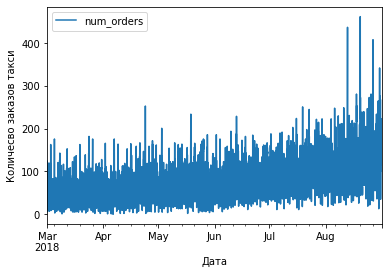

In [10]:
data.plot()
#plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси');

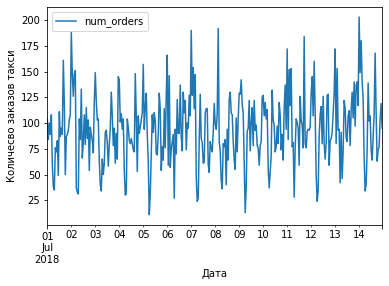

In [11]:
data['2018-07-01':'2018-07-14'].plot()
#plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси');

Визуализация основного ряда показывет, что общая динамика показывает небольшой рост.

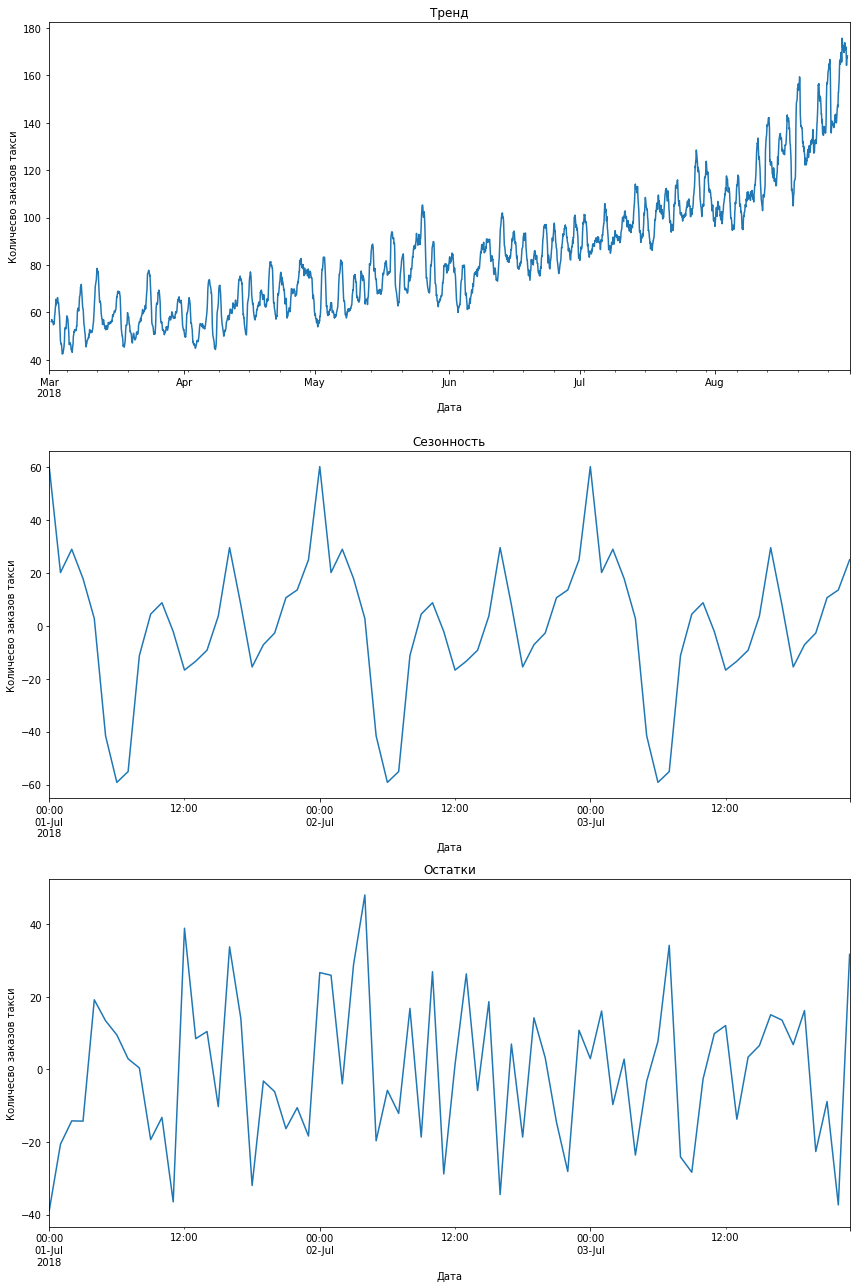

In [12]:
decomposed = seasonal_decompose(data)

#plt.figure(figsize=(6, 8))
plt.figure(figsize=(12, 18))

plt.subplot(3,1,1)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')

plt.subplot(3,1,2)
decomposed.seasonal['2018-07-01':'2018-07-3'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')

plt.subplot(3,1,3)
decomposed.resid['2018-07-01':'2018-07-3'].plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси')
plt.tight_layout()

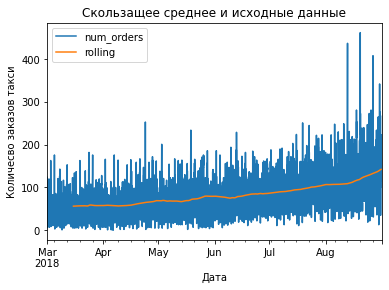

In [13]:
data['rolling']=decomposed.trend.shift().rolling(24*14).mean();
data[['num_orders','rolling']].plot();
plt.title('Скользащее среднее и исходные данные');
plt.xlabel('Дата');
plt.ylabel('Количесво заказов такси');

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
result = adfuller(data['num_orders'], autolag='AIC')
print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])

Критерий ADF: -3.068924
P-значение: 0.028940


In [16]:
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")
if result[0] < result[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд стационарен
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


**Выводы**

Визуализация основного ряда показывет, что общая динамика показывает рост. 

Анализ данных показывает что тренд ростущий и сезонностью с периодом в один день.
К вечеру наблюдается рост заказов с пиком в полночь и просадкой в 6 утра. 
Возможное объяснение, это частота рейсов высокая вечером и минимальная ночью.

Стационарность ряда проанализирована с  помощью сглаживания скользящим средним и последующей визуализацией сглаженного ряда в сравнении с исходным временным рядом. Скользящее среднее растет со временем и требует дополнительной проверки на стационарнотсь. Тест Дики-Фуллера опровергает нулевою гипотизу нестационарности  на уровне достоверности 5%, но на уровне достоверности 1% ряд нестационарен. 

## Обучение

### создание признаков

In [17]:
data['rolling_7'] = data['num_orders'].shift().rolling(7).mean()

In [18]:
data['rolling_12'] = data['num_orders'].shift().rolling(12).mean()

In [19]:
def add_lag(data,num):
    for i in range(1,num+1):
        data['lag_'+str(i)] = data['num_orders'].shift(i)

In [20]:
data.index.year.unique()

Int64Index([2018], dtype='int64', name='datetime')

In [21]:
data['hour'] = data.index.hour
data['day']=data.index.day
#data['month']=data.index.month
data['dayofweek'] = data.index.dayofweek
add_lag(data,24)
data = data.dropna()

In [22]:
data.head(5)

,num_orders,rolling,rolling_7,rolling_12,hour,day,dayofweek,lag_1,lag_2,lag_3,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-15 12:00:00,57,56.368924,36.000000,47.666667,12,15,3,58.0,54.0,65.0,...,77.0,83.0,46.0,65.0,57.0,59.0,51.0,72.0,67.0,41.0
2018-03-15 13:00:00,46,56.372706,41.285714,42.166667,13,15,3,57.0,58.0,54.0,...,81.0,77.0,83.0,46.0,65.0,57.0,59.0,51.0,72.0,67.0
2018-03-15 14:00:00,64,56.378658,47.142857,38.916667,14,15,3,46.0,57.0,58.0,...,65.0,81.0,77.0,83.0,46.0,65.0,57.0,59.0,51.0,72.0
2018-03-15 15:00:00,67,56.384239,53.857143,39.666667,15,15,3,64.0,46.0,57.0,...,123.0,65.0,81.0,77.0,83.0,46.0,65.0,57.0,59.0,51.0
2018-03-15 16:00:00,60,56.387773,58.714286,41.750000,16,15,3,67.0,64.0,46.0,...,85.0,123.0,65.0,81.0,77.0,83.0,46.0,65.0,57.0,59.0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4057 entries, 2018-03-15 12:00:00 to 2018-08-31 12:00:00
Freq: H
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4057 non-null   int64  
 1   rolling     4057 non-null   float64
 2   rolling_7   4057 non-null   float64
 3   rolling_12  4057 non-null   float64
 4   hour        4057 non-null   int64  
 5   day         4057 non-null   int64  
 6   dayofweek   4057 non-null   int64  
 7   lag_1       4057 non-null   float64
 8   lag_2       4057 non-null   float64
 9   lag_3       4057 non-null   float64
 10  lag_4       4057 non-null   float64
 11  lag_5       4057 non-null   float64
 12  lag_6       4057 non-null   float64
 13  lag_7       4057 non-null   float64
 14  lag_8       4057 non-null   float64
 15  lag_9       4057 non-null   float64
 16  lag_10      4057 non-null   float64
 17  lag_11      4057 non-null   float64
 18  lag_12      4057 non-nul

### Разбивка данных

In [24]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

In [25]:
y='num_orders'
X=list(train.columns.drop(y))
X

['rolling',
 'rolling_7',
 'rolling_12',
 'hour',
 'day',
 'dayofweek',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24']

### Маштабирование

In [26]:
scalar= StandardScaler()
pd.options.mode.chained_assignment = None
train[X] = scalar.fit_transform(train[X], train[y])
valid[X] = scalar.transform(valid[X])
test[X] = scalar.transform(test[X])

In [27]:
rmse_list_valid={}

### Dummy model

In [28]:
model_dummy = DummyRegressor(strategy='mean')
model_dummy.fit(train[X],train[y])

DummyRegressor()

In [29]:
prediction=model_dummy.predict(valid[X])
rmse=mean_squared_error(valid[y],prediction,squared=False)

In [30]:
rmse_list_valid['dummy']=rmse.round(2)
rmse

56.816768687618506

In [31]:
rmse_list_valid

{'dummy': 56.82}

### Linear model

In [32]:
model = LinearRegression()
model.fit(train[X],train[y])

LinearRegression()

In [33]:
prediction=model.predict(valid[X])
rmse=mean_squared_error(valid[y],prediction,squared=False)

In [34]:
rmse_list_valid['linear']=rmse.round(2)
rmse

34.924840686786474

In [35]:
rmse_list_valid

{'dummy': 56.82, 'linear': 34.92}

### Decision tree

In [36]:
fitting=True

In [37]:
cv_none=[(slice(None), slice(None))]

In [38]:
%%time 

if fitting:
    parameters_grid = { 
        #'max_depth':[8,12,16,20], 
        'max_depth':[None] + [i for i in range(2, 7)],
        'min_samples_leaf':[2,5,7,9]
        }
    print('Количество моделей', np.prod([len(i) for i in parameters_grid.values()]))
    model = DecisionTreeRegressor(random_state=12345)
    cv_tree = GridSearchCV(estimator=model, param_grid=parameters_grid , cv= cv_none, scoring='neg_mean_squared_error',verbose=2)    
    cv_tree.fit(train[X],train[y])
    parameters=cv_tree.best_params_
    print('parameters=',parameters)
    #print('лучший MSE =',np.sqrt(-cv_tree.best_score_))
    
    prediction_tree=cv_tree.best_estimator_.predict(valid[X])
    rmse_tree=mean_squared_error(valid[y],prediction_tree, squared=False)
    print('RMSE on validation set ', rmse_tree)
    
else:
    parameters= {'max_depth': 20, 'min_samples_leaf': 2}
    rmse_tree=41.66
    print('лучший RMSE =', rmse_tree)

Количество моделей 24
Fitting 1 folds for each of 24 candidates, totalling 24 fits
[CV] END .................max_depth=None, min_samples_leaf=2; total time=   0.1s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.1s
[CV] END .................max_depth=None, min_samples_leaf=7; total time=   0.1s
[CV] END .................max_depth=None, min_samples_leaf=9; total time=   0.1s
[CV] END ....................max_depth=2, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=5; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=7; total time=   0.0s
[CV] END ....................max_depth=2, min_samples_leaf=9; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=5; total time=   0.0s
[CV] END ....................max_depth=3, min_samples_leaf=7; total time=   0.0s
[CV] END .................

In [39]:
parameters

{'max_depth': None, 'min_samples_leaf': 2}

In [40]:
model = DecisionTreeRegressor(random_state=12345,**parameters)
model.fit(train[X],train[y])
prediction_tree=model.predict(valid[X])
rmse_tree=mean_squared_error(valid[y],prediction_tree, squared=False)
print('RMSE ', rmse_tree)

RMSE  41.65842177078125


In [41]:
rmse_list_valid['tree']=rmse_tree.round(2)

### Random forest

In [42]:
fitting=True

In [43]:
cv_none=[(slice(None), slice(None))]

In [44]:
%%time

if fitting:
    parameters_grid = {
        'n_estimators': [20,30,40], 
        #'max_depth': [12,14,16,20], 
        'max_depth':[None] + [i for i in range(2, 7)],
        'min_samples_split': [2, 3, 5]
        }
    print('Количество моделей', np.prod([len(i) for i in parameters_grid.values()]))
    model = RandomForestRegressor(random_state=12345)
    cv_forest = GridSearchCV(
        estimator=model, 
        param_grid=parameters_grid , 
        cv=cv_none, 
        scoring='neg_mean_squared_error',
        verbose=1)
    cv_forest.fit(train[X],train[y])
    parameters=cv_forest.best_params_
    print('parameters=',parameters)
    #rmse=np.sqrt(-cv_forest.best_score_)
    #print('mean rmse=',rmse)
    prediction_forest=cv_forest.best_estimator_.predict(valid[X])
    rmse=mean_squared_error(valid[y],prediction_forest, squared=False)
    print('valid set: rmse=',rmse)

else:
    parameters= {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 40}
    rmse=31.05

Количество моделей 54
Fitting 1 folds for each of 54 candidates, totalling 54 fits
parameters= {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 40}
valid set: rmse= 31.04932782197903
CPU times: user 36.9 s, sys: 0 ns, total: 36.9 s
Wall time: 36.9 s


In [45]:
model_forest = RandomForestRegressor(**parameters,random_state=12345)
model_forest.fit(train[X],train[y])
prediction_forest=model_forest.predict(valid[X])
rmse=mean_squared_error(valid[y],prediction_forest, squared=False)
print('valid set rmse=',rmse)

valid set rmse= 31.04932782197903


In [46]:
rmse_list_valid['forest']=rmse.round(2)

In [47]:
rmse_list_valid

{'dummy': 56.82, 'linear': 34.92, 'tree': 41.66, 'forest': 31.05}

### Вывод

In [48]:
rmse_list_valid

{'dummy': 56.82, 'linear': 34.92, 'tree': 41.66, 'forest': 31.05}

Рассмотрены четыре модели:
- модель среднего значения
- линейная модель
- дерево решений
- случайный лес

Модель случайного леса показала лучший результ на валидационной метрики RMSE. Выбираем ее для дальнейшего тестирования и использования.

## Тестирование

In [49]:
model_forest = RandomForestRegressor(**parameters,random_state=12345)
model_forest.fit(train[X],train[y])
prediction_forest=model_forest.predict(test[X])
rmse=mean_squared_error(test[y],prediction_forest, squared=False)
print('test set rmse=',rmse)

test set rmse= 44.229779880342456


In [50]:
prediction=model_dummy.predict(test[X])
rmse=mean_squared_error(test[y],prediction,squared=False)
rmse

86.10399028680766

In [51]:
test['prediction']=prediction_forest

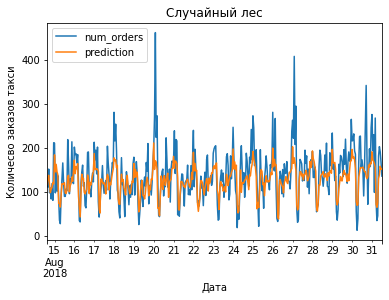

In [52]:
test[[y,'prediction']].plot()
plt.title('Случайный лес')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси');

<Figure size 864x720 with 0 Axes>

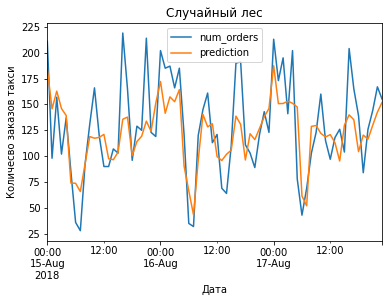

In [53]:
plt.figure(figsize=(12, 10))
test['2018-08-15':'2018-08-17'][[y,'prediction']].plot()
plt.title('Случайный лес')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси');

In [54]:
prediction_forest=model_forest.predict(data[X])
rmse=mean_squared_error(data[y],prediction_forest, squared=False)
print('full set rmse=',rmse)

full set rmse= 81.186786458806


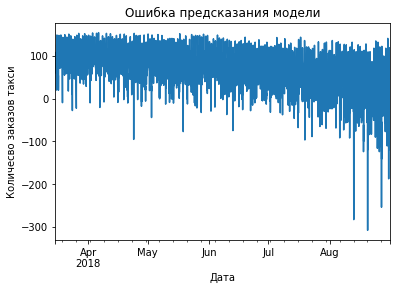

In [55]:
difference=(-data[y]+prediction_forest)
difference.plot()
plt.title('Ошибка предсказания модели')
plt.xlabel('Дата')
plt.ylabel('Количесво заказов такси');

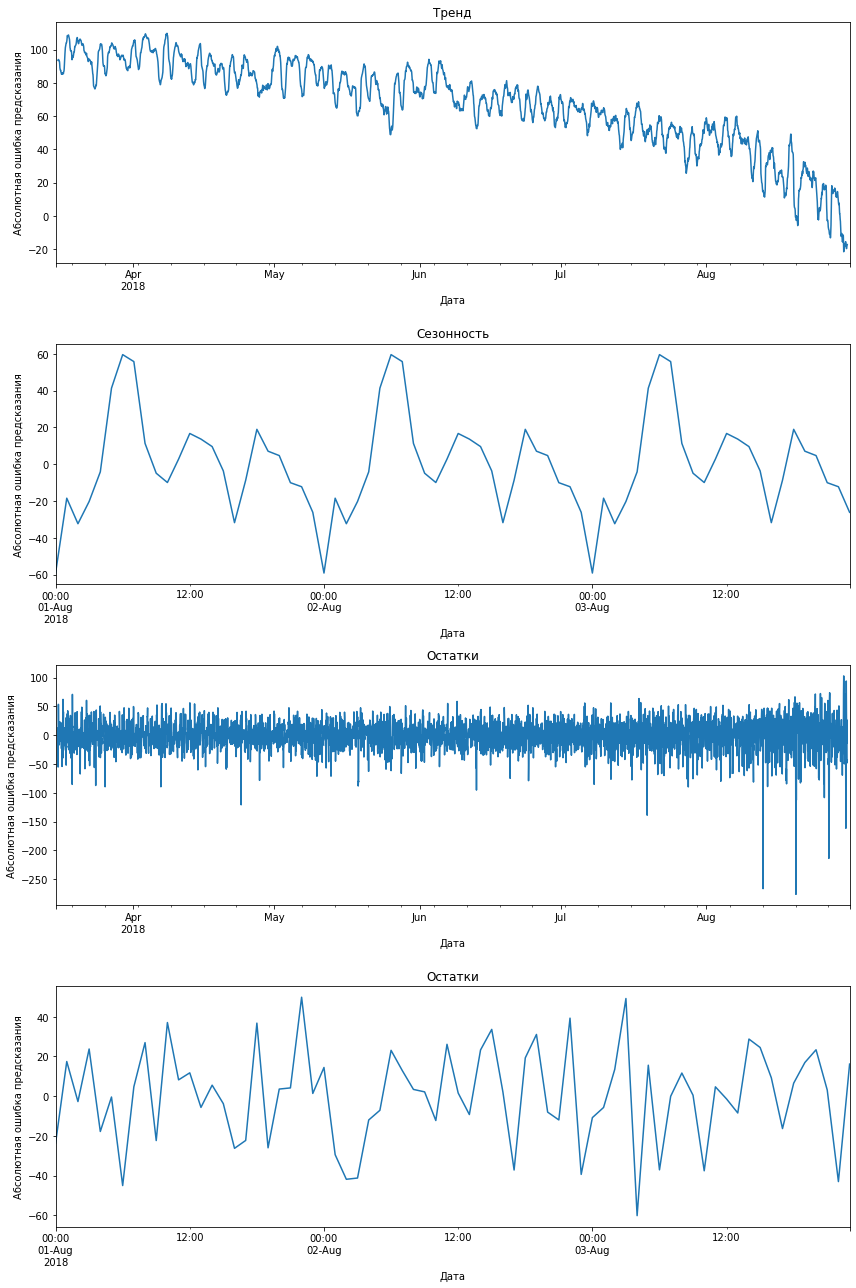

In [56]:
decomposed_diff = seasonal_decompose(difference)

plt.figure(figsize=(12, 18))

plt.subplot(4,1,1)
decomposed_diff.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Абсолютная ошибка предсказания')

plt.subplot(4,1,2)
decomposed_diff.seasonal['2018-08-01':'2018-08-3'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Абсолютная ошибка предсказания')

plt.subplot(4,1,3)
decomposed_diff.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Абсолютная ошибка предсказания')
plt.tight_layout()

plt.subplot(4,1,4)
decomposed_diff.resid['2018-08-01':'2018-08-3'].plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Абсолютная ошибка предсказания')
plt.tight_layout()

**Выводы**

Предподговка данных не выявила аномалий. Анализ данных показал, что есть слабо растущий тренд с недельной переодичностью в сезонности. Тест Дики-Фуллера не опровергает нулевою гипотизу нестационарности, т.е. ряд нестационарен на уровне достоверности 1%.

Были рассмотрены четыре модели:
- модель среднего значения
- линейная модель
- дерево решений
- случайный лес
Модель случайного леса показала лучший результ на валидационной метрики RMSE и выбрана для тестирования. 

Проведен анализ абсолютной ошибки предсказания. Самое высокая ошибка в предсказании наблюдается в часы пик (в полночь) и самые тихие часы (6 утра). Тренд ошибки нисходящий с меньшими значениями в области тестовой выборки, но при этом разброс значений ошибки гораздова выше на тестовом наборе. 

Результат метрики на тестовой выборке составил 44.2, что лучше целевого значения и два раза ниже чем значение метрики для модели среднего значения. 



Построенная модель рекоменнована для использования. 